# COMP0005 - GROUP COURSEWORK
# Experimental Evaluation of Search Data Structures and Algorithms

The cell below defines **AbstractSearchInterface**, an interface to support basic insert/search operations; you will need to implement this three times, to realise your three search data structures of choice among: (1) *2-3 Tree*, (2) *AVL Tree*, (3) *LLRB BST*; (4) *B-Tree*; and (5) *Scapegoat Tree*. <br><br>**Do NOT modify the next cell** - use the dedicated cells further below for your implementation instead. <br>

In [34]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  

class AbstractSearchInterface(ABC):
    '''
    Abstract class to support search/insert operations (plus underlying data structure)
    
    '''
        
    @abstractmethod
    def insertElement(self, element):     
        '''
        Insert an element in a search tree
            Parameters:
                    element: string to be inserted in the search tree (string)

            Returns:
                    "True" after successful insertion, "False" if element is already present (bool)
        '''
        
        pass 
    

    @abstractmethod
    def searchElement(self, element):
        '''
        Search for an element in a search tree
            Parameters:
                    element: string to be searched in the search tree (string)

            Returns:
                    "True" if element is found, "False" otherwise (bool)
        '''

        pass

Use the cell below to define any auxiliary data structure and python function you may need. Leave the implementation of the main API to the next code cells instead.

In [35]:
# ADD AUXILIARY DATA STRUCTURE DEFINITIONS AND HELPER CODE HERE

import random
import string
import timeit
import matplotlib.pyplot as plt

########################################################################################################
# AVL Tree Helpers
########################################################################################################

class AVLNode:
    def __init__(self, value: str):
        self.value: str = value
        self.left:AVLNode = None
        self.right:AVLNode = None
        self.height:int = 1

def height(node) -> int:
    if not node:
        return 0
    return node.height

def balance_factor(node) -> int:
    if not node:
        return 0
    return height(node.left) - height(node.right)

def update_height(node):
    if not node:
        return
    node.height = max(height(node.left), height(node.right)) + 1


def right_rotate(y):
    """Right rotate the unbalanced node"""

    x = y.left
    T2 = x.right
    x.right = y
    y.left = T2

    update_height(y)
    update_height(x)

    return x

def left_rotate(x):
    """Left rotate the unbalanced node"""

    y = x.right
    T2 = y.left
    y.left = x
    x.right = T2

    update_height(x)
    update_height(y)

    return y

def balance(node):
    bf = balance_factor(node)
    if bf > 1:
        if balance_factor(node.left) < 0:  # LR
            node.left = left_rotate(node.left)
        return right_rotate(node) ## LL
    if bf < -1:
        if balance_factor(node.right) > 0: # RL
            node.right = right_rotate(node.right)
        return left_rotate(node)  ## RR
    return node

########################################################################################################
# LLRB BST Helpers
########################################################################################################

# Colors: True represents RED, False represents BLACK.
RED = True
BLACK = False

class LLRBNode:
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.left = None
        self.right = None
        self.color = RED
        
def isRed(node):
    return node is not None and node.color == RED

def rotateLeft(n):
    x = n.right
    n.right = x.left
    x.left = n
    x.color = n.color
    n.color = RED
    return x

def rotateRight(n):
    x = n.left
    n.left = x.right
    x.right = n
    x.color = n.color
    n.color = RED
    return x

def flipColors(n):
    n.color = RED
    n.left.color = BLACK
    n.right.color = BLACK

########################################################################################################
# Scape Goat Tree Helpers
########################################################################################################

import math

class SGTNode:
    def __init__(self, key, value=None):
        self.key = key
        self.value = value
        self.left = None
        self.right = None
        self.size = 1  # Number of nodes in the subtree

def size(node):
    """Returns the size of a subtree rooted at 'node'."""
    return node.size if node else 0

def updateSize(node):
    """Updates the size attribute of a node based on its children's sizes."""
    if node:
        node.size = 1 + size(node.left) + size(node.right)

def flattenTree(node, arr):
    """Performs an in-order traversal and stores nodes in an array."""
    if node:
        flattenTree(node.left, arr)
        arr.append(node)
        flattenTree(node.right, arr)

def buildBalancedTree(arr, start, end):
    """Builds a balanced BST from a sorted array of nodes."""
    if start > end:
        return None
    mid = (start + end) // 2
    root = arr[mid]
    root.left = buildBalancedTree(arr, start, mid - 1)
    root.right = buildBalancedTree(arr, mid + 1, end)
    updateSize(root)
    return root

def rebuildTree(root):
    """Rebuilds a subtree rooted at 'root' into a balanced tree."""
    arr = []
    flattenTree(root, arr)
    
    if len(arr) < 2:  # ✅ Fix: Avoid unnecessary rebuilds
        return root  

    return buildBalancedTree(arr, 0, len(arr) - 1)


Use the cell below to implement the requested API by means of **AVL Tree** (if among your chosen data structure).

In [36]:
class AVLTree(AbstractSearchInterface):
    def __init__(self):
        self.root = None
        self.rotation_count = 0

    def _insert(self, node, element) -> tuple[AVLNode, bool]:
        if not node:
            return AVLNode(element), True
    
        if element == node.value:
            return node, False
        if element < node.value:
            node.left, inserted = self._insert(node.left, element)
        else:
            node.right, inserted = self._insert(node.right, element)
        
        if not inserted:
            return node, False
        
        update_height(node)
        return self.balance(node), True

    def insertElement(self, element):
        self.root, inserted = self._insert(self.root, element)
        return inserted
    
    def _search(self, node, element) -> bool:
        if not node:
            return False

        if element == node.value:
            return True

        if element < node.value:
            return self._search(node.left, element)
        else:
            return self._search(node.right, element)

    def searchElement(self, element):     
        
        return self._search(self.root, element)
    
    def balance(self, node):
        bf = balance_factor(node)
        if bf > 1 or bf < -1:
            self.rotation_count += 1  # 检测到不平衡时，旋转次数加 1
        # 原有的平衡逻辑
        if bf > 1:
            if balance_factor(node.left) < 0:  # LR 情况
                node.left = left_rotate(node.left)
            return right_rotate(node)  # LL 情况
        if bf < -1:
            if balance_factor(node.right) > 0:  # RL 情况
                node.right = right_rotate(node.right)
            return left_rotate(node)  # RR 情况
        return node

Use the cell below to implement the requested API by means of **LLRB BST** (if among your chosen data structure).

In [37]:
        
class LLRBBST(AbstractSearchInterface):
        
    def __init__(self):
        self.root = None

    def insertElement(self, element):

        def _insert(node, element):
            if node is None:
                return LLRBNode(element, element)  # Create a new red node
            
            if element < node.key:
                node.left = _insert(node.left, element)
            elif element > node.key:
                node.right = _insert(node.right, element)
            else:
                return node
            
            # Fix Red-Black Tree Violations
            if isRed(node.right) and not isRed(node.left):
                node = rotateLeft(node)
            if isRed(node.left) and isRed(node.left.left):
                node = rotateRight(node)
            if isRed(node.left) and isRed(node.right):
                flipColors(node)
            
            return node
        
        self.root = _insert(self.root, element)
        self.root.color = BLACK  # Root should always be black
        return True

    def searchElement(self, element):
        current = self.root
        while current is not None:
            if element < current.key:
                current = current.left
            elif element > current.key:
                current = current.right
            else:
                return True
        return False

Use the cell below to implement the requested API by means of **Scapegoat Tree** (if among your chosen data structure).

In [38]:
class ScapegoatTree(AbstractSearchInterface):
        
    def __init__(self, alpha=0.75):
        self.root = None
        self.alpha = alpha  # Scapegoat threshold
        self.max_size = 0  # Track maximum tree size before rebuilding

    def _insert(self, node, key, value):
        """Recursive insertion function."""
        if node is None:
            return SGTNode(key, value)

        if key < node.key:
            node.left = self._insert(node.left, key, value)
        elif key > node.key:
            node.right = self._insert(node.right, key, value)
        else:
            node.value = value  # Update value if key exists
        
        updateSize(node)

        # 🔹 Rebuild only if the **subtree** is unbalanced
        if size(node.left) > self.alpha * size(node) or size(node.right) > self.alpha * size(node):
            node = rebuildTree(node)  # ✅ Fix: Avoid infinite loop

        return node


    def insertElement(self, key):
        """Public insert method that ensures tree balance."""
        self.root = self._insert(self.root, key, None)
        if size(self.root) > self.alpha * self.max_size:  # 🔹 Only update max_size if not rebuilt
            self.max_size = size(self.root)
        return True


    def _search(self, node, key):
        """Recursive search function."""
        if node is None:
            return False
        if key == node.key:
            return True
        elif key < node.key:
            return self._search(node.left, key)
        else:
            return self._search(node.right, key)

    def searchElement(self, key):
        """Public search method."""
        return self._search(self.root, key)


Use the cell below to implement the **synthetic data generator** needed by your experimental framework (be mindful of code readability and reusability).

In [39]:
from typing import List
import random
import string

class TestDataGenerator:
    '''
    A class to generate synthetic test data with configurable parameters.
    '''
    def __init__(self, size, string_length= 10):
        """
        Initialize the TestDataGenerator with size and string length parameters.
        
        Args:
            size (int): Number of strings to generate
            string_length (int): Length of each generated string (default: 10)
        """
        self.size = size
        self.string_length = string_length
        self.character_set = string.ascii_lowercase  # Extracted as a class attribute

    def generate_random_strings(self) -> List[str]:
        """Generate a list of random strings with specified length.
        
        Returns:
            List[str]: A list of random lowercase strings
        """
        return [
            ''.join(random.choice(self.character_set) 
                   for _ in range(self.string_length))
            for _ in range(self.size)
        ]

    def sorted_strings(self, random_strings: List[str]) -> List[str]:
        """Sort a list of strings in ascending order.
        
        Args:
            random_strings (List[str]): List of strings to sort
            
        Returns:
            List[str]: Sorted list of strings
        """
        return sorted(random_strings)
    
    def almost_sorted_strings(self, random_strings: List[str]) -> List[str]:
        """Generate an almost sorted list by making limited random swaps.
        
        Args:
            random_strings (List[str]): List of strings to modify
            
        Returns:
            List[str]: Almost sorted list with some elements swapped
        """
        SWAP_FRACTION = 0.1  
        
        data = self.sorted_strings(random_strings)
        num_swaps = int(len(data) * SWAP_FRACTION)
        
        for _ in range(num_swaps):
            i, j = random.sample(range(len(data)), 2)
            data[i], data[j] = data[j], data[i]
            
        return data
    
    def generate_nonexistent_strings(self) -> List[str]:
        """
        Generate strings that are guaranteed not to exist in the tree.
        These strings will contain uppercase letters and digits, while inserted strings are lowercase only.
        """
        character_set = string.ascii_uppercase + string.digits  # Uppercase letters and digits (A-Z, 0-9)
        return [
            ''.join(random.choice(character_set) 
                   for _ in range(self.string_length))
            for _ in range(self.size)
        ]


Use the cell below to implement the requested **experimental framework** (be mindful of code readability and reusability).

In [40]:
from typing import List, Tuple
import random
import timeit
import matplotlib.pyplot as plt
import math

class ExperimentalFramework:
    def __init__(
        self,
        data_structures: List,
        dataset_size: int,
        target_points: int,
        repeat_times: int,
        search_sample_size: int,
        repeat_group_times: int,  # 保留参数以兼容，但不再使用
        variance_threshold: float,
        window_size: int,
        smooth_base_window: int,
        smooth_max_window: int
    ):
        """
        Initialize the ExperimentalFramework.

        Args:
            data_structures (List): List of data structure classes to test.
            dataset_size (int): Size of the dataset.
            target_points (int): Target number of recording points.
            repeat_times (int): Number of times to repeat each operation for timing.
            search_sample_size (int): Number of elements to sample for search tests.
            repeat_group_times (int): Number of times to repeat group insertion for timing (不再使用).
            variance_threshold (float): Threshold for variance in smoothing.
            window_size (int): Window size for smoothing.
            smooth_base_window (int): Base window size for smoothing.
            smooth_max_window (int): Maximum window size for smoothing.
        """
        self.data_structures = data_structures
        self.dataset_size = dataset_size
        self.target_points = target_points
        self.repeat_times = repeat_times
        self.search_sample_size = search_sample_size
        self.repeat_group_times = repeat_group_times  # 保留参数，但不再使用
        self.variance_threshold = variance_threshold
        self.window_size = window_size
        self.smooth_base_window = smooth_base_window
        self.smooth_max_window = smooth_max_window
        self.results = {
            ds_class.__name__: {
                'Random Insert': {'sizes': [], 'times': []},
                'Sorted Insert': {'sizes': [], 'times': []},
                'Almost Sorted Insert': {'sizes': [], 'times': []},
                'Search': {'sizes': [], 'times': []},
                'Search Nonexistent': {'sizes': [], 'times': []}
            } for ds_class in self.data_structures
        }
        self.sampling_points = self.calculate_sampling_points()

    def calculate_sampling_points(self) -> List[int]:
        """
        Calculate sampling points using a logarithmic distribution with partitioning.

        Returns:
            List[int]: List of indices where recording should occur.
        """
        early_points = list(range(1, 100, 2))  # 1, 3, 5, ..., 99
        early_count = len(early_points)
        remaining_points = self.target_points - early_count
        if remaining_points <= 0:
            return early_points
        start_size = 100
        end_size = self.dataset_size
        a = (math.log(end_size) - math.log(start_size)) / (remaining_points - 1) if remaining_points > 1 else 0
        b = math.log(start_size)
        log_points = set()
        for i in range(remaining_points):
            size = round(math.exp(a * i + b))
            if size > self.dataset_size:
                break
            if size >= start_size:
                log_points.add(size)
        sampling_points = early_points + sorted(log_points)
        if sampling_points[-1] != self.dataset_size:
            sampling_points.append(self.dataset_size)
        return sampling_points

    def should_record_at_index(self, index: int) -> bool:
        """
        Determine if we should record at the given index.

        Args:
            index (int): Current index in the dataset (0-based).

        Returns:
            bool: True if we should record at this index, False otherwise.
        """
        return (index + 1) in self.sampling_points

    def smooth_times(self, raw_times: List[float]) -> List[float]:
        """
        Smooth the raw times using a dynamic window.

        Args:
            raw_times (List[float]): List of raw times to smooth.

        Returns:
            List[float]: Smoothed times.
        """
        num_points = len(raw_times)
        base_window = min(self.smooth_base_window, num_points // 2)
        max_window = min(self.smooth_max_window, num_points // 2)
        smoothed = []
        for i in range(num_points):
            if i < base_window or i >= num_points - base_window:
                window = raw_times[max(0, i - base_window):i + base_window + 1]
            else:
                window = raw_times[i - base_window:i + base_window + 1]
            mean = sum(window) / len(window)
            variance = sum((x - mean) ** 2 for x in window) / len(window) if len(window) > 1 else 0
            window_size = min(base_window + int(variance * 1e6), max_window)
            start = max(0, i - window_size // 2)
            end = min(len(raw_times), i + window_size // 2 + 1)
            smoothed.append(sum(raw_times[start:end]) / (end - start))
        return smoothed

    def run_search_test(self, tree, inserted_elements: List[str], search_nonexistent_base: List[str]) -> Tuple[float, float]:
        """
        Run search test on the given tree.

        Args:
            tree: The tree to search on.
            inserted_elements (List[str]): List of elements already inserted into the tree.
            search_nonexistent_base (List[str]): List of nonexistent elements for search.

        Returns:
            Tuple[float, float]: (avg_search_time, avg_search_nonexistent_time)
                - avg_search_time: Average time to search for existing elements (in microseconds).
                - avg_search_nonexistent_time: Average time to search for nonexistent elements (in microseconds).
        """
        if not inserted_elements or not search_nonexistent_base:
            raise ValueError("Inserted elements and nonexistent elements must not be empty.")
        search_sample = random.sample(inserted_elements, min(self.search_sample_size, len(inserted_elements)))
        total_search_time = 0
        for search_item in search_sample:
            timer = timeit.Timer(lambda: tree.searchElement(search_item))
            times = timer.repeat(repeat=self.repeat_times, number=1)
            avg_search_time = sum(times) / self.repeat_times
            total_search_time += avg_search_time
        avg_search_time = total_search_time / len(search_sample) * 1e6
        search_nonexistent_sample = random.sample(search_nonexistent_base, min(self.search_sample_size, len(search_nonexistent_base)))
        total_search_nonexistent_time = 0
        for search_item in search_nonexistent_sample:
            timer = timeit.Timer(lambda: tree.searchElement(search_item))
            times = timer.repeat(repeat=self.repeat_times, number=1)
            avg_search_time = sum(times) / self.repeat_times
            total_search_nonexistent_time += avg_search_time
        avg_search_nonexistent_time = total_search_nonexistent_time / len(search_nonexistent_sample) * 1e6
        return avg_search_time, avg_search_nonexistent_time

    def run_insertion_test(
        self,
        dataset: List[str],
        ds_class,
        search_nonexistent_base: List[str] = None,
        run_search: bool = False
    ) -> Tuple[List[int], List[float], List[int], List[float], List[float]]:
        """
        Run insertion test for a given dataset and data structure, optionally with search tests.

        Args:
            dataset (List[str]): Dataset to insert.
            ds_class: Data structure class to test.
            search_nonexistent_base (List[str], optional): List of nonexistent elements for search.
            run_search (bool): Whether to run search tests (only for Random Insert).

        Returns:
            Tuple[List[int], List[float], List[int], List[float], List[float]]:
                - insert_sizes: List of tree sizes at which insertion times were recorded.
                - insert_times: List of insertion times (in microseconds).
                - search_sizes: List of tree sizes at which search times were recorded (if run_search=True).
                - search_times: List of search times for existing elements (if run_search=True).
                - search_nonexistent_times: List of search times for nonexistent elements (if run_search=True).
        """
        if not dataset or not ds_class:
            raise ValueError("Dataset and data structure class must not be empty.")
        if run_search and not search_nonexistent_base:
            raise ValueError("search_nonexistent_base must be provided if run_search is True.")

        tree = ds_class()
        insert_sizes = []
        insert_times = []
        search_sizes = [] if run_search else None
        search_times = [] if run_search else None
        search_nonexistent_times = [] if run_search else None
        size = 0  # 当前树的大小

        i = 0
        while i < len(dataset):
            # 确定当前分组（group）
            start = i
            group = []
            while i < len(dataset) and not self.should_record_at_index(i):
                group.append(dataset[i])
                i += 1
            if i < len(dataset):
                group.append(dataset[i])
                i += 1

            if group:  # 如果有元素需要插入
                size += len(group)

                # 直接在主树上插入并计时
                timer = timeit.Timer(lambda: [tree.insertElement(item) for item in group])
                times = timer.repeat(repeat=self.repeat_times, number=1)
                avg_time = sum(times) / self.repeat_times / len(group)

                # 记录插入时间
                insert_sizes.append(size)
                insert_times.append(avg_time * 1e6)

                if ds_class.__name__ == "AVLTree":
                    print(f"AVLTree - Size: {size}, Avg Insert Time: {avg_time * 1e6:.2f} μs")
                    if hasattr(tree, 'rotation_count'):
                        print(f"Rotation Count: {tree.rotation_count}")

                # 运行搜索测试（如果启用）
                if run_search:
                    inserted_elements = dataset[:i]
                    avg_search_time, avg_search_nonexistent_time = self.run_search_test(
                        tree, inserted_elements, search_nonexistent_base
                    )
                    search_times.append(avg_search_time)
                    search_nonexistent_times.append(avg_search_nonexistent_time)
                    search_sizes.append(size)

        # 处理剩余元素
        if i < len(dataset):
            group = dataset[i:]
            if group:
                size += len(group)

                timer = timeit.Timer(lambda: [tree.insertElement(item) for item in group])
                times = timer.repeat(repeat=self.repeat_times, number=1)
                avg_time = sum(times) / self.repeat_times / len(group)

                insert_sizes.append(size)
                insert_times.append(avg_time * 1e6)

                if ds_class.__name__ == "AVLTree":
                    print(f"AVLTree - Size: {size}, Avg Insert Time: {avg_time * 1e6:.2f} μs")
                    if hasattr(tree, 'rotation_count'):
                        print(f"Rotation Count: {tree.rotation_count}")

                if run_search:
                    inserted_elements = dataset[:len(dataset)]
                    avg_search_time, avg_search_nonexistent_time = self.run_search_test(
                        tree, inserted_elements, search_nonexistent_base
                    )
                    search_times.append(avg_search_time)
                    search_nonexistent_times.append(avg_search_nonexistent_time)
                    search_sizes.append(size)

        return insert_sizes, insert_times, search_sizes, search_times, search_nonexistent_times

    def store_results(
        self,
        tree_name: str,
        metric: str,
        sizes: List[int],
        times: List[float],
        search_sizes: List[int] = None,
        search_times: List[float] = None,
        search_nonexistent_times: List[float] = None
    ):
        """
        Smooth and store results for a given metric.

        Args:
            tree_name (str): Name of the tree.
            metric (str): Metric being tested (e.g., 'Random Insert').
            sizes (List[int]): List of tree sizes.
            times (List[float]): List of times to store.
            search_sizes (List[int], optional): List of tree sizes for search.
            search_times (List[float], optional): List of search times for existing elements.
            search_nonexistent_times (List[float], optional): List of search times for nonexistent elements.
        """
        smoothed_times = self.smooth_times(times)
        self.results[tree_name][metric]['sizes'] = sizes
        self.results[tree_name][metric]['times'] = smoothed_times

        if search_sizes is not None:
            smoothed_search_times = self.smooth_times(search_times)
            smoothed_search_nonexistent_times = self.smooth_times(search_nonexistent_times)
            self.results[tree_name]['Search']['sizes'] = search_sizes
            self.results[tree_name]['Search']['times'] = smoothed_search_times
            self.results[tree_name]['Search Nonexistent']['sizes'] = search_sizes
            self.results[tree_name]['Search Nonexistent']['times'] = smoothed_search_nonexistent_times

    def log_results(
        self,
        tree_name: str,
        metric: str,
        insert_times: List[float],
        search_times: List[float] = None,
        search_nonexistent_times: List[float] = None,
        smoothed_search_times: List[float] = None,
        smoothed_search_nonexistent_times: List[float] = None
    ):
        """
        Log the results for a given metric.

        Args:
            tree_name (str): Name of the tree.
            metric (str): Metric being tested (e.g., 'Random Insert').
            insert_times (List[float]): List of insertion times.
            search_times (List[float], optional): List of raw search times for existing elements.
            search_nonexistent_times (List[float], optional): List of raw search times for nonexistent elements.
            smoothed_search_times (List[float], optional): List of smoothed search times for existing elements.
            smoothed_search_nonexistent_times (List[float], optional): List of smoothed search times for nonexistent elements.
        """
        print(f"{tree_name} - {metric} Insert Times: {insert_times[:5]}...{insert_times[-5:]}")
        if search_times is not None:
            print(f"{tree_name} - Raw Search Times: {search_times[:5]}...{search_times[-5:]}")
            print(f"{tree_name} - Raw Search Nonexistent Times: {search_nonexistent_times[:5]}...{search_nonexistent_times[-5:]}")
            print(f"{tree_name} - Smoothed Search Times: {smoothed_search_times[:5]}...{smoothed_search_times[-5:]}")
            print(f"{tree_name} - Smoothed Search Nonexistent Times: {smoothed_search_nonexistent_times[:5]}...{smoothed_search_nonexistent_times[-5:]}")

    def run(self, datasets: dict):
        """
        Run the experiment for all datasets and data structures.

        Args:
            datasets (dict): Dictionary of datasets to test.
        """
        search_nonexistent_base = datasets['Search Nonexistent']
        
        # Process each dataset
        for metric, dataset in datasets.items():
            if metric in ['Search', 'Search Nonexistent']:
                continue

            for ds_class in self.data_structures:
                tree_name = ds_class.__name__

                # Run insertion test, with search tests only for Random Insert
                insert_sizes, insert_times, search_sizes, search_times, search_nonexistent_times = self.run_insertion_test(
                    dataset,
                    ds_class,
                    search_nonexistent_base=search_nonexistent_base,
                    # run_search=(metric == 'Random Insert')
                    run_search=False
                )

                # Smooth and store results
                self.store_results(
                    tree_name,
                    metric,
                    insert_sizes,
                    insert_times,
                    search_sizes if metric == 'Random Insert' else None,
                    search_times if metric == 'Random Insert' else None,
                    search_nonexistent_times if metric == 'Random Insert' else None
                )

                # Log results
                self.log_results(
                    tree_name,
                    metric,
                    insert_times,
                    search_times if metric == 'Random Insert' else None,
                    search_nonexistent_times if metric == 'Random Insert' else None,
                    self.results[tree_name]['Search']['times'] if metric == 'Random Insert' else None,
                    self.results[tree_name]['Search Nonexistent']['times'] if metric == 'Random Insert' else None
                )

        self.plot_results()

    def plot_results(self):
        """
        Plot the results for all metrics.
        """
        metrics = ['Random Insert', 'Sorted Insert', 'Almost Sorted Insert', 'Search', 'Search Nonexistent']
        titles = [
            'Random Insert Performance',
            'Sorted Insert Performance',
            'Almost Sorted Insert Performance',
            'Search Performance (Existing Elements)',
            'Search Performance (Nonexistent Elements)'
        ]
        colors = {'AVLTree': 'blue', 'LLRBBST': 'green', 'ScapegoatTree': 'red'}

        for metric, title in zip(metrics, titles):
            plt.figure(figsize=(12, 8))
            for tree_name in self.results:
                sizes = self.results[tree_name][metric]['sizes']
                times = self.results[tree_name][metric]['times']
                plt.plot(
                    sizes,
                    times,
                    label=tree_name,
                    marker='o',
                    color=colors[tree_name],
                    linewidth=2,
                    markersize=4
                )
            plt.xlabel('Tree Size')
            plt.ylabel('Average Time (μs)')
            plt.title(title)
            plt.legend()
            plt.grid(True, which="both", ls="--")
            plt.ylim(bottom=0)
            plt.tight_layout()
            plt.show()

Use the cell below to illustrate the python code you used to **fully evaluate** your three chosen search data structures and algortihms. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each data structure using such data, collect information about their execution time, plot results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

AVLTree - Size: 1, Avg Insert Time: 1.67 μs
Rotation Count: 0
AVLTree - Size: 3, Avg Insert Time: 1.27 μs
Rotation Count: 1
AVLTree - Size: 5, Avg Insert Time: 0.48 μs
Rotation Count: 1
AVLTree - Size: 7, Avg Insert Time: 0.68 μs
Rotation Count: 3
AVLTree - Size: 9, Avg Insert Time: 0.50 μs
Rotation Count: 3
AVLTree - Size: 11, Avg Insert Time: 0.50 μs
Rotation Count: 4
AVLTree - Size: 13, Avg Insert Time: 0.57 μs
Rotation Count: 5
AVLTree - Size: 15, Avg Insert Time: 0.55 μs
Rotation Count: 7
AVLTree - Size: 17, Avg Insert Time: 0.67 μs
Rotation Count: 9
AVLTree - Size: 19, Avg Insert Time: 0.57 μs
Rotation Count: 10
AVLTree - Size: 21, Avg Insert Time: 0.53 μs
Rotation Count: 10
AVLTree - Size: 23, Avg Insert Time: 0.60 μs
Rotation Count: 11
AVLTree - Size: 25, Avg Insert Time: 0.66 μs
Rotation Count: 13
AVLTree - Size: 27, Avg Insert Time: 0.65 μs
Rotation Count: 14
AVLTree - Size: 29, Avg Insert Time: 0.69 μs
Rotation Count: 16
AVLTree - Size: 31, Avg Insert Time: 0.61 μs
Rotation 

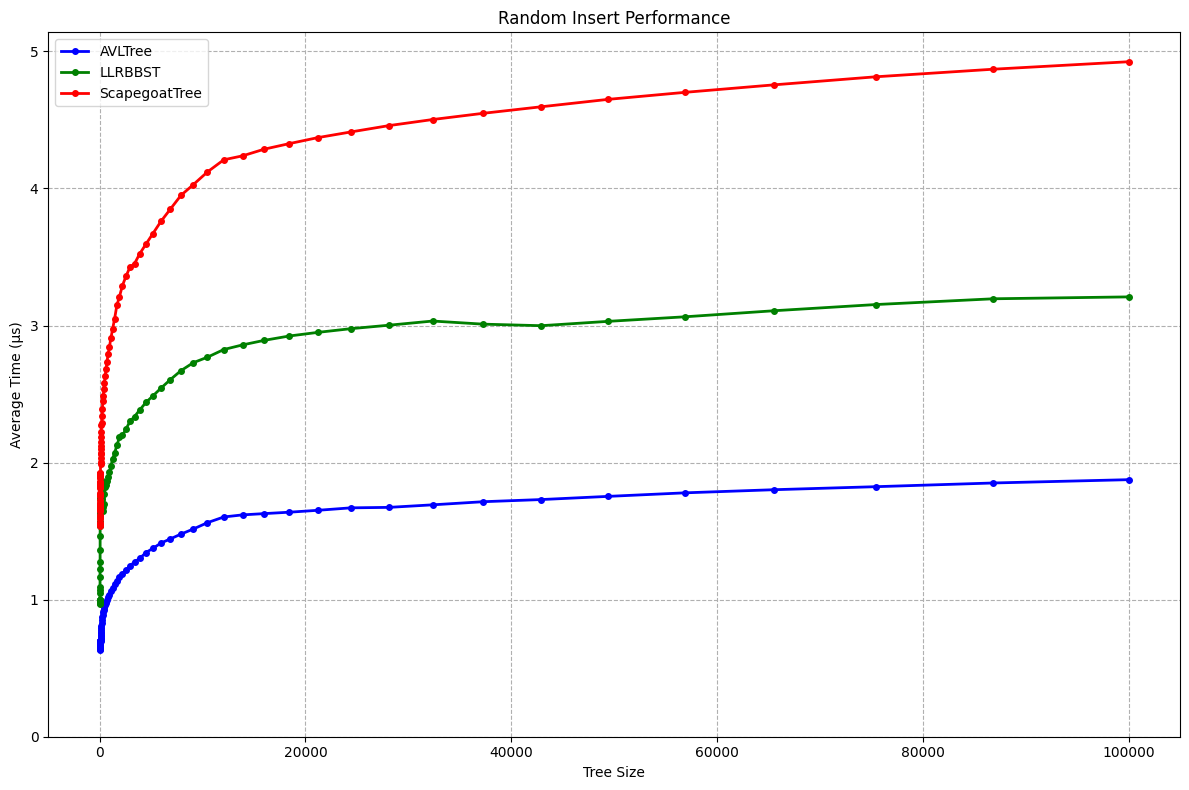

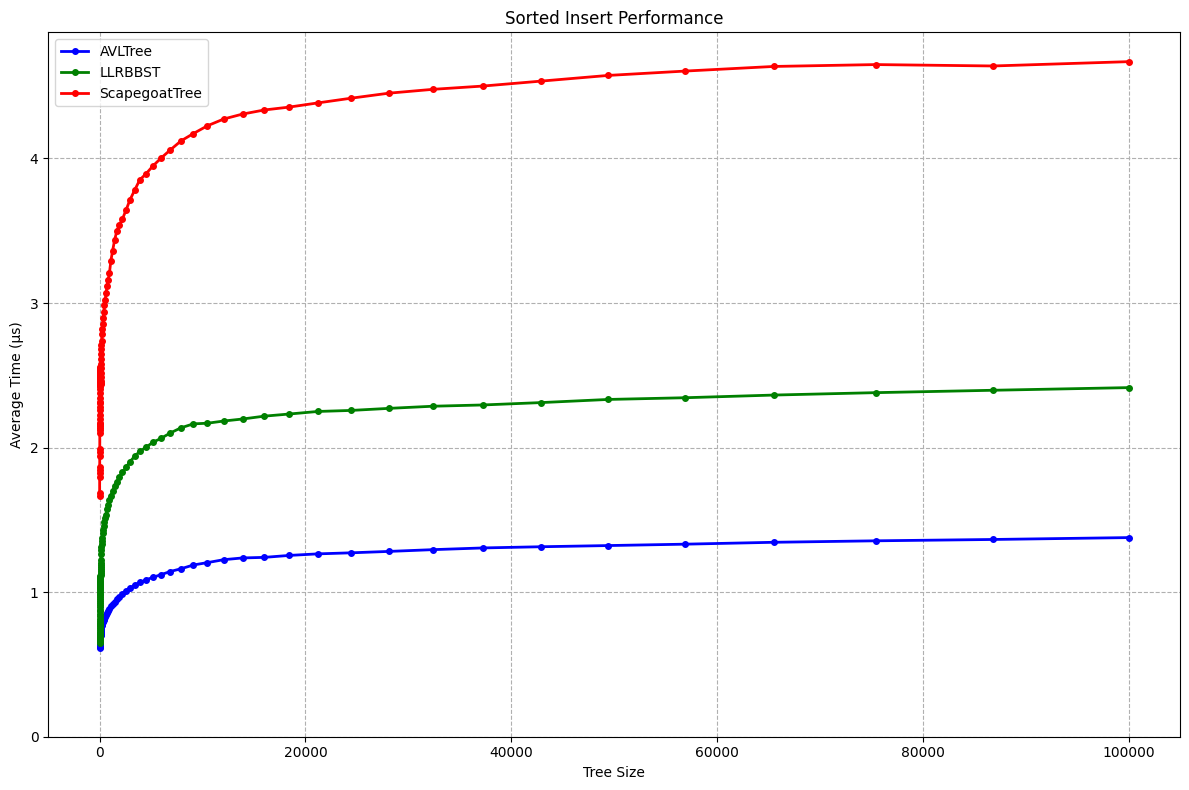

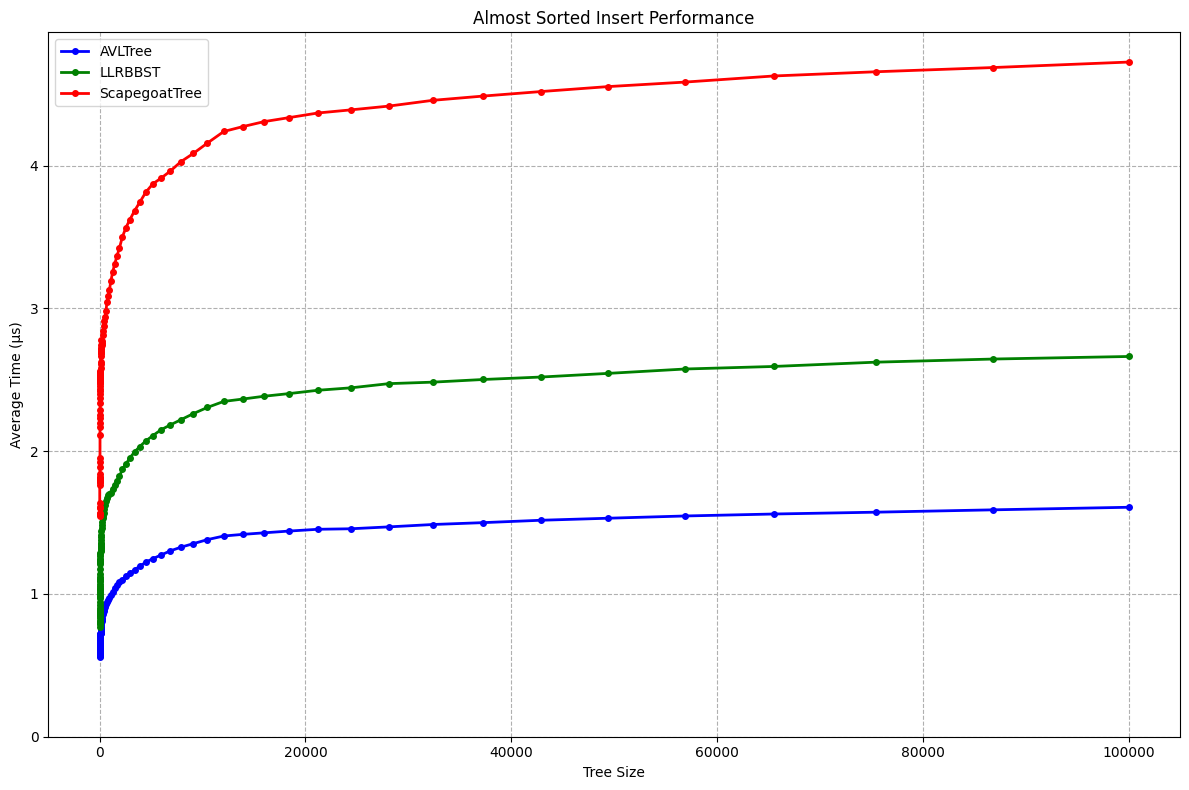

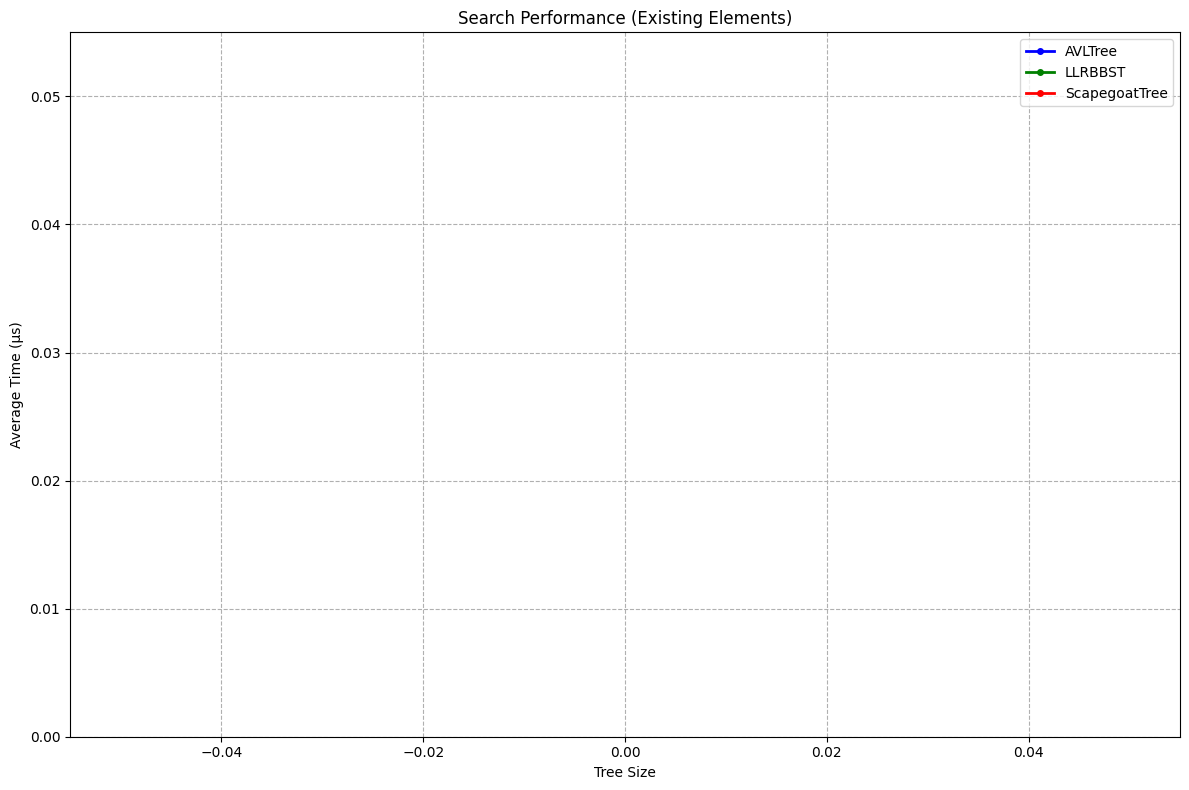

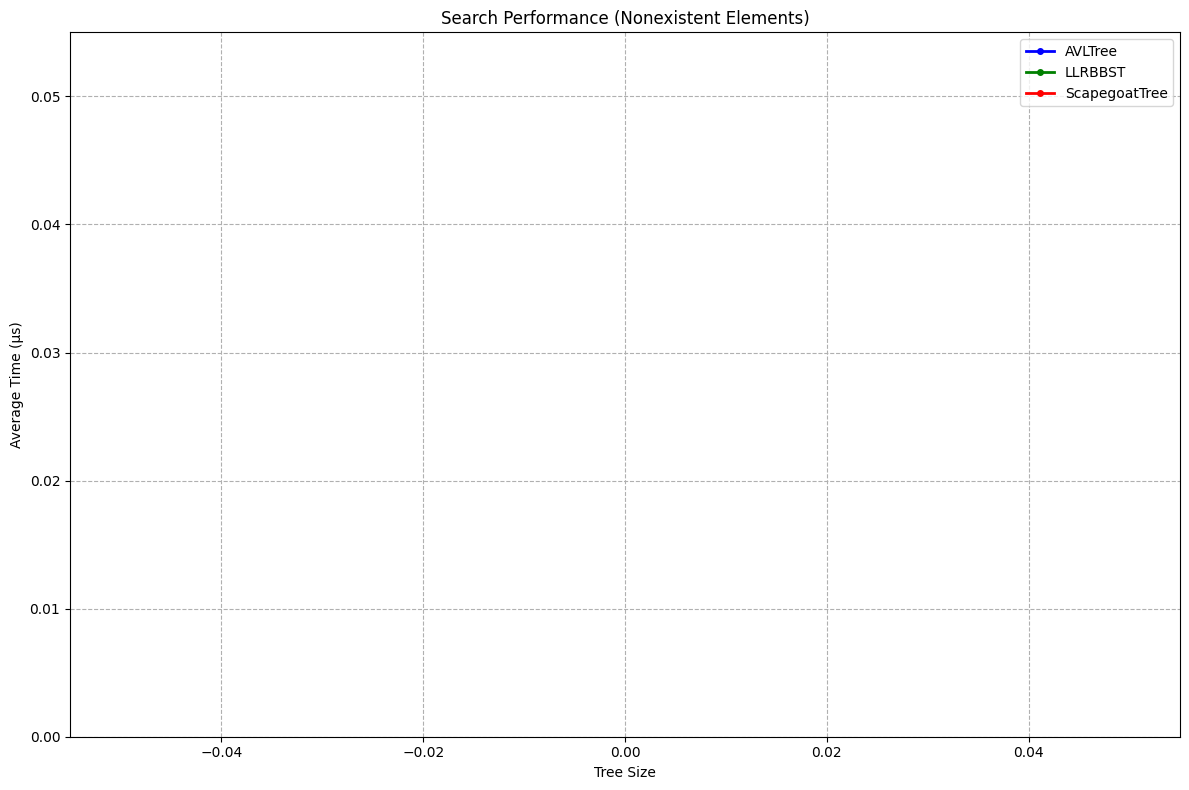

{'data_structures': [<class '__main__.AVLTree'>, <class '__main__.LLRBBST'>, <class '__main__.ScapegoatTree'>], 'dataset_size': 100000, 'target_points': 100, 'repeat_times': 10, 'search_sample_size': 100, 'repeat_group_times': 10, 'variance_threshold': 1e-06, 'window_size': 5, 'smooth_base_window': 10, 'smooth_max_window': 30}


In [41]:
# Main execution block with centralized parameter tuning
if __name__ == '__main__':
    # Instantiate TestDataGenerator
    dataset_size = 100000
    string_length = 5
    data_gen = TestDataGenerator(dataset_size, string_length)

    # Generate all string sequences together
    base_random = data_gen.generate_random_strings()
    datasets = {
        'Random Insert': base_random,
        'Sorted Insert': data_gen.sorted_strings(base_random),
        'Almost Sorted Insert': data_gen.almost_sorted_strings(base_random),
        'Search Nonexistent': data_gen.generate_nonexistent_strings()
    }

    # Define data structures
    data_structures = [AVLTree, LLRBBST, ScapegoatTree]  # Assume these are defined

    # Centralized parameter tuning
    experiment_params = {
        'data_structures': data_structures,
        'dataset_size': dataset_size,
        'target_points': 100,
        'repeat_times': 10,              
        'search_sample_size': 100,
        'repeat_group_times': 10,
        'variance_threshold': 1e-6,      
        'window_size': 5,                
        'smooth_base_window': 10,        
        'smooth_max_window': 30,         
    }

    # Instantiate ExperimentalFramework with tuned parameters
    experiment = ExperimentalFramework(**experiment_params)
    
    # Run the experiment
    experiment.run(datasets)

    print(experiment_params)